In [1]:
# %pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# %pip install transformers[torch]==4.30.2
# %pip install accelerate -U
# %pip install optuna
!pip install fastai spacy
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 66.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Combined 2065 rows datasets :

In [3]:
import pandas as pd

file_path =  "/content/drive/MyDrive/DistilBERT-7-Mei/combined_dataset.csv"
df = pd.read_csv(file_path)

In [4]:
print(df.shape)

(2066, 5)


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, Dataset
import torch
from tqdm import tqdm

# 1. Load your dataset
# df = pd.read_csv("/content/combined_dataset.csv")
texts = df["clean_text"].tolist()
labels = df["encoded_label"].tolist()

# 2. Train-test split
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# 3. Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = AutoModel.from_pretrained("distilbert-base-uncased").eval().cuda()

# 4. Custom dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = TextDataset(X_train_texts, y_train, tokenizer)
test_dataset = TextDataset(X_test_texts, y_test, tokenizer)

# 5. Extract CLS embeddings
def extract_cls_embeddings(model, dataset, batch_size=16):
    dataloader = DataLoader(dataset, batch_size=batch_size)
    embeddings = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting embeddings"):
            input_ids = batch["input_ids"].cuda()
            attention_mask = batch["attention_mask"].cuda()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            cls_embeds = outputs.last_hidden_state[:, 0, :]  # [CLS] token
            embeddings.append(cls_embeds.cpu().numpy())
    return np.vstack(embeddings)

X_train = extract_cls_embeddings(bert_model, train_dataset)
X_test = extract_cls_embeddings(bert_model, test_dataset)



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Extracting embeddings: 100%|██████████| 26/26 [00:01<00:00, 20.66it/s]


# Instalasi Optuna :

In [6]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 12.5 MB/s eta 0:00:00


# Optuna Objective :

In [7]:
import optuna
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# -----------------------------
# 1. Optuna untuk Linear & RBF
# -----------------------------
def objective(trial):
    # Pilih kernel (linear / rbf)
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf"])

    # Regularization
    C = trial.suggest_loguniform("C", 1e-3, 1e3)

    # Gamma hanya untuk rbf
    if kernel == "rbf":
        gamma = trial.suggest_categorical("gamma", ["scale", "auto"])
    else:
        gamma = "scale"

    # Model SVM
    model = SVC(
        kernel=kernel,
        C=C,
        gamma=gamma,
        probability=True,
        random_state=42
    )

    # Cross-validation scoring
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1_macro")
    return scores.mean()

# Jalankan Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best Hyperparameters (Linear/RBF):", study.best_params)
print("Best F1 Score (Linear/RBF):", study.best_value)


[I 2025-10-01 07:12:41,264] A new study created in memory with name: no-name-5fa7b452-4e04-4be1-873d-178939e058e6
/tmp/ipython-input-2024614656.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-3, 1e3)
[I 2025-10-01 07:12:47,080] Trial 0 finished with value: 0.7837937876885639 and parameters: {'kernel': 'linear', 'C': 841.1387751125217}. Best is trial 0 with value: 0.7837937876885639.
/tmp/ipython-input-2024614656.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-3, 1e3)
[I 2025-10-01 07:12:52,457] Trial 1 finished with value: 0.35468732247767115 and parameters: {'kernel': 'linear', 'C': 0.0

Best Hyperparameters (Linear/RBF): {'kernel': 'rbf', 'C': 334.40394834096384, 'gamma': 'scale'}
Best F1 Score (Linear/RBF): 0.8014219776185215


#  2. Pearson Kernel + SVM

In [8]:
from sklearn.preprocessing import StandardScaler

# Scaling dulu biar stabil
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hitung Pearson kernel
def pearson_kernel(X1, X2):
    X1_centered = X1 - X1.mean(axis=1, keepdims=True)
    X2_centered = X2 - X2.mean(axis=1, keepdims=True)
    num = np.dot(X1_centered, X2_centered.T)
    denom = np.linalg.norm(X1_centered, axis=1, keepdims=True) * np.linalg.norm(X2_centered, axis=1, keepdims=True).T
    return num / (denom + 1e-8)

K_train = pearson_kernel(X_train_scaled, X_train_scaled)
K_test = pearson_kernel(X_test_scaled, X_train_scaled)

In [16]:
# (Opsional) Tuning C untuk Pearson kernel via Optuna
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import optuna

def objective_pearson(trial):
    # Regularization
    C = trial.suggest_loguniform("C", 1e-3, 1e3)

    # Model SVM dengan precomputed kernel
    model = SVC(
        kernel="precomputed",
        C=C,
        probability=True,
        random_state=42
    )

    # Cross-validation scoring using kernel matrix
    # We need to create cross-validation splits and generate the kernel matrix for each split
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    for train_index, val_index in kf.split(X_train_scaled):
        K_train_fold = pearson_kernel(X_train_scaled[train_index], X_train_scaled[train_index])
        K_val_fold = pearson_kernel(X_train_scaled[val_index], X_train_scaled[train_index])
        model.fit(K_train_fold, np.array(y_train)[train_index])
        score = f1_score(np.array(y_train)[val_index], model.predict(K_val_fold), average="macro")
        scores.append(score)

    return np.mean(scores)

# Jalankan Optuna
study_p = optuna.create_study(direction="maximize")
study_p.optimize(objective_pearson, n_trials=50)

print("Best Hyperparameters (Pearson):", study_p.best_params)
print("Best F1 Score (Pearson):", study_p.best_value)

[I 2025-10-01 07:36:20,502] A new study created in memory with name: no-name-36d9bb66-e741-4841-9a8d-215091074094
/tmp/ipython-input-2781528896.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-3, 1e3)
[I 2025-10-01 07:36:23,144] Trial 0 finished with value: 0.772805758146415 and parameters: {'C': 182.53993190399638}. Best is trial 0 with value: 0.772805758146415.
/tmp/ipython-input-2781528896.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-3, 1e3)
[I 2025-10-01 07:36:23,788] Trial 1 finished with value: 0.7801606565217037 and parameters: {'C': 5.8567524520169565}. Best is trial 1 with val

Best Hyperparameters (Pearson): {'C': 13.139815224662586}
Best F1 Score (Pearson): 0.7861631441049785


In [17]:
# Train final Pearson SVM
best_C = study_p.best_params["C"]
svm = SVC(kernel="precomputed", C=best_C, random_state=42)
svm.fit(K_train, y_train)

SVC(C=13.139815224662586, kernel='precomputed', random_state=42)


🎯 Pearson-SVM F1 Score (macro): 0.8313

📋 Classification Report:

              precision    recall  f1-score   support

         0.0     0.8442    0.8553    0.8497       228
         1.0     0.8197    0.8065    0.8130       186

    accuracy                         0.8333       414
   macro avg     0.8319    0.8309    0.8313       414
weighted avg     0.8332    0.8333    0.8332       414


📊 Confusion Matrix (tabel):

            Pred 0.0  Pred 1.0
Actual 0.0       195        33
Actual 1.0        36       150


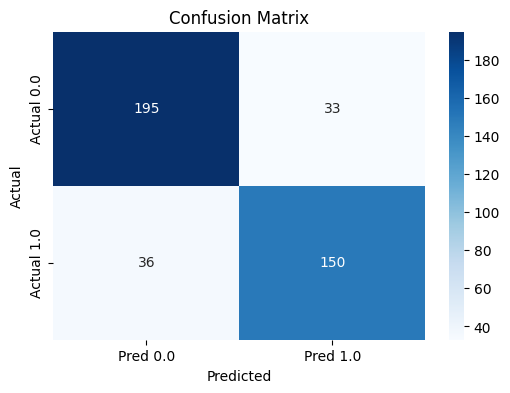

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 8. Predict and evaluate
y_pred = svm.predict(K_test)
f1 = f1_score(y_test, y_pred, average="macro")
print(f"\n🎯 Pearson-SVM F1 Score (macro): {f1:.4f}")

print("\n📋 Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

# 9. Confusion Matrix (tabel)
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index=[f"Actual {i}" for i in np.unique(y_test)],
                     columns=[f"Pred {i}" for i in np.unique(y_test)])

print("\n📊 Confusion Matrix (tabel):\n")
print(cm_df)

# 10. Confusion Matrix (visualisasi heatmap)
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [21]:
!git clone https://github.com/WilliamAxelC/Indonesian-Cyberbullying-Detection-with-Distilbert.git


Cloning into 'Indonesian-Cyberbullying-Detection-with-Distilbert'...
remote: Enumerating objects: 172, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 172 (delta 91), reused 131 (delta 50), pack-reused 0 (from 0)
Receiving objects: 100% (172/172), 15.59 MiB | 11.50 MiB/s, done.
Resolving deltas: 100% (91/91), done.


In [22]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
